In [1]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

# Dictionaries

In [2]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [3]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    }
}

In [4]:
osoba = ['ideał', 'wróg'] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'zacofanie'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'sąd': ['sprawiedliwość', 'niesprawiedliwość'],
    'imigranci': ['przyjaciele', 'wrogowie'],
    'ekologia': ['', ''],
    'emigracja': ['szansa', 'ucieczka'], # szansa
    'pis': partia,
    'platforma': partia,
    'duda': osoba,
    'morawiecki': osoba,
    'szydło': osoba,
    'kaczyński': osoba,
    'kwaśniewski': osoba,
    'lewica': poglad,
    'prawica': poglad,
    'lgbt': ['tolerancja', ''],
    'europa': ['wspólnota', 'podział'], # rozłam
    'rosja': kraj,
    'stany': kraj,
    'premier': osoba,
    'prezydent': osoba,
    'opozycja': partia,
    'rząd': partia,
    'sejm': partia,
    'polska': ['oaza', ''],
    'putin': ['sojusznik', 'wróg'],
    'trump': ['sojusznik', 'wróg'],
    'ukraina': kraj,
    'media': ['', ''],
    'bank': ['bezpieczeństwo', 'wyzysk'],
    'niemcy': kraj,
    'papież': osoba,
    'kościół': ['oparcie', 'firma'],
    'korwin': osoba,
    'rydzyk': osoba,
    'feminizm': ['równość', 'patriarchat'],
    'leszek+miller': osoba,
}

In [5]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [6]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

# Read data

## Wyborcza

In [7]:
wyborcza_articles = []
for filename in listdir('data/wyborcza/articles'):
    try:
        wyborcza_articles.append(pd.read_csv('data/wyborcza/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
wyborcza_articles = pd.concat(wyborcza_articles)
wyborcza_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
wyborcza_articles['short'] = wyborcza_articles['short'].str.replace(r'(.|..)\n', '')
wyborcza_articles = wyborcza_articles[~wyborcza_articles['long'].str.contains('W odpowiedzi do @', na = False) == True]
wyborcza_articles = wyborcza_articles[['title', 'short', 'long']]
wyborcza_articles = wyborcza_articles.dropna()
wyborcza_articles = wyborcza_articles[wyborcza_articles['title'].duplicated() == False]
wyborcza_articles = wyborcza_articles[wyborcza_articles['short'] != '0']
wyborcza_articles['website'] = 'wyborcza'
wyborcza_articles['brand'] = 'agora'
wyborcza_articles['country'] = 'pl'

In [8]:
wyborcza_articles = wyborcza_articles[
    (
        wyborcza_articles['title'] + ' ' +
        wyborcza_articles['long'] + ' ' +
        wyborcza_articles['short'] 
    ).str.contains(r""+"|".join(list(keyword_reference_words.keys())).replace('+', ' ')) == True
]

In [9]:
len(wyborcza_articles)

36486

In [10]:
wyborcza_articles.sample(5).head(5)

,title,short,long,website,brand,country
666,Fotografie wyjęte z zakurzonych szuflad,"Plaża nad Wisłą, ulica Matejki z końca XIX wie...",Artur Dobiegała i Olga Długokęcka ze Stowarzys...,wyborcza,agora,pl
154,Zwolniony kasjer skarży pracodawcę w sądzie,- W czasie kryzysu zastraszeni pracownicy nie ...,W czwartek przed zielonogórskim sądem odbyła s...,wyborcza,agora,pl
557,Łódzcy celnicy podsumowali rok 2012. Dziś ich ...,Zlikwidowali 15 nielegalnych rozlewni alkoholu...,Przypadający w dniu 26 stycznia Międzynarodowy...,wyborcza,agora,pl
617,Szok gdańskiej Platformy,W Gdańsku partia rządząca osiągnęła wyraźnie g...,W poniedziałek gdańscy działacze Platformy wpa...,wyborcza,agora,pl
538,To kto wreszcie jest ojcem dziecka Katarzyny P...,W styczniu sąd orzeknie wreszcie: kto jest ojc...,"Dwa lata temu, w listopadzie, Katarzyna P., wi...",wyborcza,agora,pl


## Gazeta

In [11]:
gazeta_articles = []
for filename in listdir('data/gazeta/articles'):
    try:
        gazeta_articles.append(pd.read_csv('data/gazeta/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
gazeta_articles = pd.concat(gazeta_articles)
gazeta_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
gazeta_articles = gazeta_articles[['title', 'short', 'long']]
gazeta_articles = gazeta_articles[gazeta_articles['title'].duplicated() == False]
gazeta_articles['website'] = 'gazeta'
gazeta_articles['brand'] = 'agora'
gazeta_articles['country'] = 'pl'

In [12]:
len(gazeta_articles)

12075

In [13]:
gazeta_articles.sample(5).head()

,title,short,long,website,brand,country
53,"""Dzieciństwo w żelaznych sarkofagach"", czyli b...",Jak wygląda rzeczywistość bez szczepień? Bruta...,Obywatelski projekt nowelizacji ustawy przewid...,gazeta,agora,pl
6,"Dziewanna wielkokwiatowa - właściwości, zastos...",Dziewanna wielkokwiatowa jest rośliną lecznicz...,Dziewanna wielkokwiatowa (verbascum densifloru...,gazeta,agora,pl
128,Wicemarszałkowie zajmą się Cimoszewiczem,Prezydium Sejmu rozpatrzy jednak wniosek Włodz...,Wicemarszałek Sejmu Tomasz Nałęcz (SdPl) twier...,gazeta,agora,pl
132,Dieta antyhistaminowa: na czym polega. Kto pow...,"Dieta antyhistaminowa to dieta eliminacyjna, s...",Dieta antyhistaminowa - kiedy jest konieczna?\...,gazeta,agora,pl
1,Prezes YouTube właśnie przyjechała do Polski. ...,Szefowa YouTube jest dzisiaj w Polsce. Plan po...,Prezes You Tube nazywa się Susan Wójcicki i je...,gazeta,agora,pl


## Fakt

In [14]:
fakt_articles = []
for filename in listdir('data/fakt/articles'):
    tmp_df = pd.read_csv('data/fakt/articles/'+filename, header = None)
    tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    tmp_df[filename] = 1
    tmp_df[filename] = tmp_df[filename].fillna(0)
    fakt_articles.append(tmp_df)
fakt_articles = pd.concat(fakt_articles, sort = False)
fakt_articles = fakt_articles[~fakt_articles['long'].isna()]
fakt_articles['long'] = fakt_articles.apply(lambda x: x['long'][len(x['short']):], axis = 1)
fakt_articles = fakt_articles[['title', 'short', 'long']]
fakt_articles = fakt_articles[fakt_articles['title'].duplicated() == False]
fakt_articles['website'] = 'fakt'
fakt_articles['country'] = 'de/ch'
fakt_articles['brand'] = 'ringier'
fakt_articles = fakt_articles.dropna()

In [15]:
len(fakt_articles)

19165

In [16]:
fakt_articles.head(3)

,title,short,long,website,country,brand
0,Pierwsze posiedzenie Sejmu. Przemówienie Andrz...,Pierwsze posiedzenie Sejmu otworzył marszałek ...,Andrzej Duda wygłosił orędzie na inauguracyjn...,fakt,de/ch,ringier
1,"Jędraszewski o gender, LGBT i karcie WHO: ""Obł...",Abp. Marek Jędraszewski wygłosił kazanie podcz...,Homilii arcybiskupa Marka Jędraszewskiego słu...,fakt,de/ch,ringier
2,"Hołownia zdradził, ile do tej pory wyłożył z w...",Szymon Hołownia w niedzielę ogłosił swój start...,Szymon Hołownia w miniony weekend w Teatrze S...,fakt,de/ch,ringier


## Onet

In [17]:
onet_articles = []
for filename in listdir('data/onet/articles'):
    tmp_df = pd.read_csv('data/onet/articles/'+filename, header = None)
    try:
        tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    except:
        tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    # tmp_df[filename] = 1
    onet_articles.append(tmp_df)
onet_articles = pd.concat(onet_articles, sort = False)
onet_articles = onet_articles[['title', 'short', 'long']]
onet_articles = onet_articles[onet_articles['title'].duplicated() == False]
onet_articles = onet_articles.dropna()
onet_articles['website'] = 'onet'
onet_articles['country'] = 'de/ch'
onet_articles['brand'] = 'ringier'

In [18]:
len(onet_articles)

16472

In [19]:
onet_articles.head(3)

,title,short,long,website,country,brand
0,Sondaż IBRiS dla Onetu. Spadają notowania Andr...,Prezydent Andrzej Duda cieszy się najwyższym z...,Andrzej Duda od wielu miesięcy cieszy się najw...,onet,de/ch,ringier
1,Bogdan Klich: to wielki strategiczny błąd prez...,- Decyzja wycofania polskich wojsk z Iraku pow...,- Głos opozycji jest niezbędny i trzeba go wys...,onet,de/ch,ringier
2,Izraelskie media informują o decyzji prezydent...,Izraelskie media informują za agencjami prasow...,"Andrzej Duda, którego nie poproszono o wystąpi...",onet,de/ch,ringier


## Newsweek

In [20]:
newsweek_articles = []
for filename in listdir('data/newsweek/articles'):
    tmp_df = pd.read_csv('data/newsweek/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    newsweek_articles.append(tmp_df)
newsweek_articles = pd.concat(newsweek_articles, sort = False)
newsweek_articles = newsweek_articles[['title', 'short', 'long']]
newsweek_articles = newsweek_articles[newsweek_articles['title'].duplicated() == False]
newsweek_articles = newsweek_articles.dropna()
newsweek_articles['website'] = 'newsweek'
newsweek_articles['country'] = 'de/ch'
newsweek_articles['brand'] = 'ringier'

In [21]:
len(newsweek_articles)

1605

In [22]:
newsweek_articles.head(3)

,title,short,long,website,country,brand
0,"OPINIA\nPiS tak zohydza Unię Europejską, że wk...",Prezes Jarosław Kaczyński chce stworzyć nowe z...,Spektakl zatytułowany „zła unia” miał w minion...,newsweek,de/ch,ringier
1,"„Jestem przekonany, że Biedroń będzie gryzł tr...",Jedną nogą w Brukseli Robert Biedroń chce walc...,"Po niedzielnej konwencji w Słupsku, na której ...",newsweek,de/ch,ringier
2,Andrzej Duda walczy o wyborców Konfederacji?„N...,"– Mam nadzieję, że mimo huraganowych ataków, k...",Kampania prezydencka jeszcze się nie rozpoczęł...,newsweek,de/ch,ringier


## TVN

In [23]:
tvn_articles_list = []
for filename in listdir('data/tvn/articles'):
    tmp_df = pd.read_csv('data/tvn/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    tvn_articles_list.append(tmp_df)
tvn_articles = pd.concat(tvn_articles_list, sort = False)
tvn_articles = tvn_articles[['title', 'short', 'long']]
tvn_articles = tvn_articles[tvn_articles['title'].duplicated() == False]
tvn_articles = tvn_articles.dropna()
tvn_articles['website'] = 'tvn'
tvn_articles['country'] = 'us'
tvn_articles['brand'] = 'discovery'

In [24]:
len(tvn_articles)

35232

In [25]:
tvn_articles.sample(5).head()

,title,short,long,website,country,brand
374,PO: Wyrok do przewidzenia. Działania CBA polit...,- Wyrok sądu wobec byłej posłanki PO Beaty Saw...,"Zdaniem Olszewskiego, wyrok sądu wobec Sawicki...",tvn,us,discovery
195,"Skazany za gwałt w Anglii, chce ułaskawienia w...",Sąd w Wielkiej Brytanii skazał Polaka na podwó...,- Po południu zarejestrowaliśmy to pismo. Prze...,tvn,us,discovery
138,W hołdzie Kilarowi - księga kondolencyjna w ur...,"W niedzielę, w wieku 81 lat zmarł Wojciech Kil...","Księga kondolencyjna, w której wszyscy, którzy...",tvn,us,discovery
427,Niemiecki polityk ma nowych współlokatorów. To...,Martin Patzelt to polityk niemieckiej partii C...,Martin Patzelt był przez osiem lat naburmistrz...,tvn,us,discovery
820,Walka o przyszłość Hongkongu. Protesty \nw roc...,Problemy gospodarcze i społeczne nie zostaną r...,Na przyjęciu z okazji rocznicy powrotu Hongkon...,tvn,us,discovery


## Sputnik

In [26]:
sputnik_list = []
for filename in listdir('data/sputnik/articles'):
    tmp_df = pd.read_csv('data/sputnik/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    sputnik_list.append(tmp_df)
sputnik_articles = pd.concat(sputnik_list, sort = False)
sputnik_articles = sputnik_articles[['title', 'short', 'long']]
sputnik_articles = sputnik_articles[sputnik_articles['title'].duplicated() == False]
sputnik_articles = sputnik_articles.dropna()
sputnik_articles['website'] = 'sputnik'
sputnik_articles['country'] = 'ru'
sputnik_articles['brand'] = 'sjegodnia'

In [27]:
len(sputnik_articles)

16302

In [28]:
sputnik_articles.sample(5).head()

,title,short,long,website,country,brand
87,Bazy NATO w Polsce? Tego nie chcą Amerykanie!,Prezydent Duda bardzo kategorycznie domaga się...,Serdecznie Państwa witam.Przed mikrofonem Leon...,sputnik,ru,sjegodnia
25,30 lat minęło jak jeden dzień,6 lutego obchodziliśmy okrągłą rocznicę rozpoc...,/ JANEK SKARZYNSKI W Parlamencie Europejskim o...,sputnik,ru,sjegodnia
327,"Media: USA zawieszą wsparcie dla Gwatemali, Ho...",Prezydent Stanów Zjednoczonych Donald Trump na...,"„Na polecenie sekretarza stanu Mike'a Pompeo, ...",sputnik,ru,sjegodnia
62,Akrobatka wisiała na zębach nad wodospadem Nia...,Akrobatka Erendira Wallenda nowym osiągnięciem...,"Trick, w którym Erendira Wallenda zawisła nad ...",sputnik,ru,sjegodnia
586,„Negocjacje z Rosją powinny być priorytetem dl...,"Europoseł Nathan Gill powiedział, że negocjacj...","W XXI wieku oczekujemy od polityków, że będą r...",sputnik,ru,sjegodnia


## TVP

## Concentrate data

In [29]:
df = pd.concat([
    wyborcza_articles,
    gazeta_articles,
    fakt_articles,
    onet_articles,
    newsweek_articles,
    tvn_articles,
    sputnik_articles
], axis = 0, sort = False)

In [30]:
df.sample(3).head(3)

,title,short,long,website,brand,country
548,"PO odwoła się \nod umorzenia ""zakumuflowanej o...",Platforma Obywatelska odwoła się od umorzenia ...,- Z pewnością się odwołamy. Naszym zdaniem pra...,tvn,discovery,us
243,Ostatni wpis Leskiego przed śmiercią. Bolesne ...,"""Wbrew wielu szczegółom, to nie był aż tak zły...",Na kilka godzin przed śmiercią Krzysztof Lesk...,fakt,ringier,de/ch
757,Australia: pożary w centrum imigrantów,Mieszkańcy ośrodka dla imigrantów na peryferia...,,onet,ringier,de/ch


## Data check

In [31]:
df.sample(1).values

array([['Pionierska wyprawa: chce zebrać tyle złotych, ile pokona kilometrów',
        'Janusz Marmurowicz-Voss, absolwent kierunku zarządzanie na UMK, wyruszy w lipcu na wyprawę rowerową o nazwie "Polska NAJ". Celem jest zebranie funduszy na pomoc wybranej rodzinie w charytatywnej akcji "Szlachetna Paczka".',
        'Wyprawa jest projektem pionierskim. Trasa liczy ponad 3000 km. – Zamierzam dotrzeć rowerem lub – jeśli nie będzie to możliwe z przyczyn czysto technicznych – pieszo do wszystkich geograficznie najdalej wysuniętych miejsc Polski: na północy, południu, wschodzie i zachodzie. Odwiedzę też geograficzny środek Polski, największą polską depresję i wejdę na najwyższy polski szczyt – mówi Janusz Marmurowicz-Voss.\nPostanowił, że podróż po Polsce połączy ze zbieraniem środków na pomoc potrzebującym. Zgodnie z hasłem wyprawy „Szlachetne pomaganie przez aktywne działanie” chce zebrać minimum tyle złotych, ile kilometrów pokona. Zachęcając innych do wolontariatu podczas akcji „Szlac

In [32]:
df['long'] = df['long'].str.replace('\n\n', ' ').str.replace('\n', ' ')

## Data summary

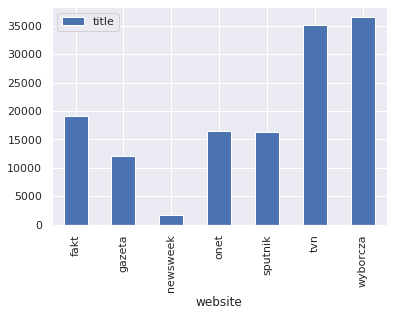

In [36]:
df\
    [['website', 'title']]\
    .groupby('website')\
    .count()\
    .plot(kind = 'bar')

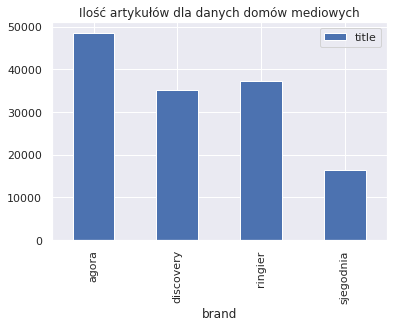

In [37]:
df\
    [['brand', 'title']]\
    .groupby('brand')\
    .count()\
    .plot(kind = 'bar', title = 'Ilość artykułów dla danych domów mediowych')

# Write

In [35]:
len(df)

137337

In [38]:
for i, tmp_df in enumerate(np.array_split(df, 10)):
    tmp_df.to_csv('data/concatenated/'+str(i), index = False)